# Ungraded Lab: First GAN with MNIST

This lab will demonstrate the simple [Generative Adversarial Network (GAN)](https://arxiv.org/abs/1406.2661) you just saw in the lectures. This will be trained on the MNIST dataset and you will see how the network creates new images.

## Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Utilities

We've provided a helper function to plot fake images. This will be used to visualize sample outputs from the GAN while it is being trained.

In [2]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Download and Prepare the Dataset

You will first load the MNIST dataset. For this exercise, you will just be using the training images so you might notice that we are not getting the `test` split nor the training labels below. You will also preprocess these by normalizing the pixel values.

In [3]:
# load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

11490434/11490434 [==============================] - 2s 0us/step


You will create batches of the train images so it can be fed to the model while training.

In [4]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Build the Model

You will now create the two main parts of the GAN: 
* generator - creates the fake data
* discriminator - determines if an image is fake or real

You will stack Dense layers using the Sequential API to build these sub networks.

### Generator

The generator takes in random noise and uses it to create fake images. For that, this model will take in the shape of the random noise and will output an image with the same dimensions of the MNIST dataset (i.e. 28 x 28). 

[SELU](https://arxiv.org/abs/1706.02515) is found to be a good activation function for GANs and we use that in the first two dense networks. The final dense networks is activated with a sigmoid because we want to generate pixel values between 0 and 1. This is then reshaped to the dimensions of the MNIST dataset.

In [5]:
# declare shape of the noise input
random_normal_dimensions = 32

# build the generator model
generator = keras.models.Sequential([                                 
    keras.layers.Dense(64, activation="selu", input_shape=[random_normal_dimensions]),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

Let's see a sample output of an untrained generator. As you expect, this will be just random points. After training, these will resemble digits from the MNIST dataset.

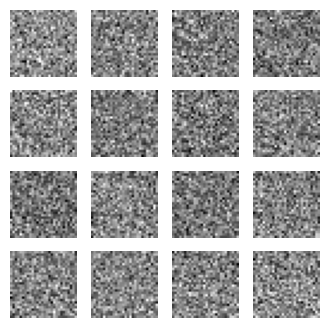

In [6]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, random_normal_dimensions])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_multiple_images(test_image, n_cols=4)

### Discriminator

The discriminator takes in the input (fake or real) images and determines if it is fake or not. Thus, the input shape will be that of the training images. This will be flattened so it can be fed to the dense networks and the final output is a value between 0 (fake) and 1 (real).

Like the generator, we use SELU activation in the first two dense networks and we activate the final network with a sigmoid.

In [7]:
# build the discriminator model
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

We can append these two models to build the GAN.

In [8]:
gan = keras.models.Sequential([generator, discriminator])

## Configure Training Parameters

You will now prepare the models for training. You can measure the loss with `binary_crossentropy` because you're expecting labels to be either 0 (fake) or 1 (real).

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

Next, you will define the training loop. This consists of two phases:

* Phase 1 - trains the discriminator to distinguish between fake or real data
* Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, you will display a sample gallery of images to see the fake images being created by the generator. The details of how these steps are carried out are shown in the code comments below.

In [10]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    # start loop
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # plot the fake images used to train the discriminator
        plot_multiple_images(fake_images, 8)                     
        plt.show()      

You can scroll through the output cell to see how the fake images improve per epoch.

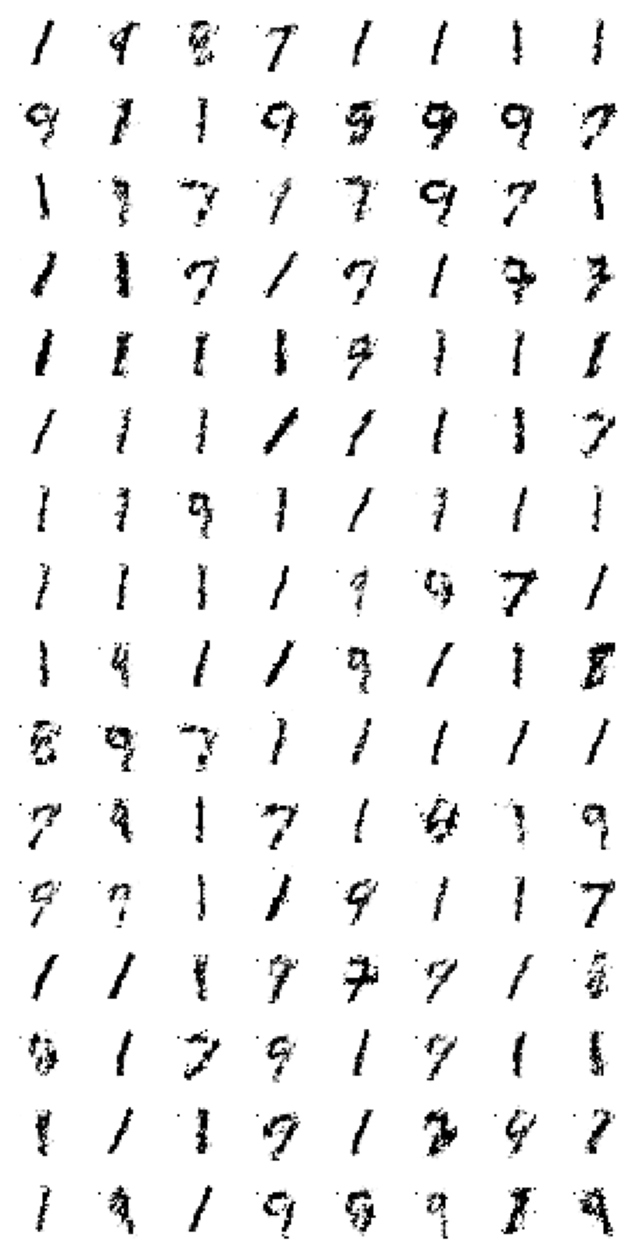

In [11]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)

You might notice that as the training progresses, the model tends to be biased towards a subset of the numbers such as 1, 7, and 9. We'll see how to improve this in the next sections of the course.